# Channel Head Coupling Analysis

This notebook analyzes the coupling between channel heads in a drainage network derived from a DEM using **TopoToolbox (Python)**.  
We:
- Load the DEM and derive flow and stream networks.
- Identify outlets, confluences, and channel heads.
- Compute *first-meet pairs* of channel heads per confluence.
- Evaluate which pairs are *coupled* (touching).
- Visualize coupled pairs and outlet subgraphs.

---

In [1]:
# === Setup ===
import sys, pathlib, numpy as np, pandas as pd
import matplotlib.pyplot as plt
import topotoolbox as tt3
import topotoolbox._stream as _stream

# Add project root so "src" package is visible
project_root = pathlib.Path("/Users/guypi/Projects/channel-heads")
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

# Imports from your src package
from src.first_meet_pairs_for_outlet import first_meet_pairs_for_outlet
from src.coupling_analysis import CouplingAnalyzer
from src.stream_utils import outlet_node_ids_from_streampoi
from src.plotting_utils import (
    plot_coupled_pair,
    plot_outlet_view,
    plot_all_coupled_pairs_for_outlet,
    plot_all_coupled_pairs_for_outlet_3d
)

## 1. Load and Preprocess DEM

We load the SRTM DEM from disk and mask out low elevation values (<1200 m).  
A basic visualization helps confirm the data integrity.

name: output_srtm
path: /Users/guypi/Projects/channel-heads/data/raw/output_srtm.tif
rows: 878
cols: 814
cellsize: 0.000833333333333144
bounds: BoundingBox(left=-118.25875000001403, bottom=36.332083333338716, right=-117.58041666668085, top=37.063750000005214)
transform: | 0.00, 0.00,-118.26|
| 0.00,-0.00, 37.06|
| 0.00, 0.00, 1.00|
coordinate system (Geographic): EPSG:4326
maximum z-value: 4257.0
minimum z-value: 317.0


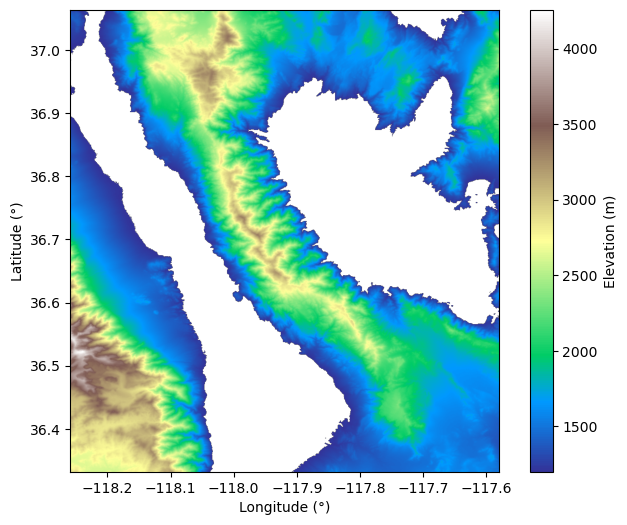

In [2]:
dem = tt3.read_tif("/Users/guypi/Projects/channel-heads/data/raw/output_srtm.tif")
dem.info()

# Mask out low elevations
dem.z[dem.z < 1200] = np.nan

fig, ax = plt.subplots(figsize=(8,6))
im = dem.plot(ax=ax, cmap='terrain')
ax.set_xlabel('Longitude (°)')
ax.set_ylabel('Latitude (°)')
plt.colorbar(im, ax=ax, label="Elevation (m)")

## 2. Flow and Stream Network

We derive a `FlowObject` from the DEM and create a `StreamObject` using a threshold area.

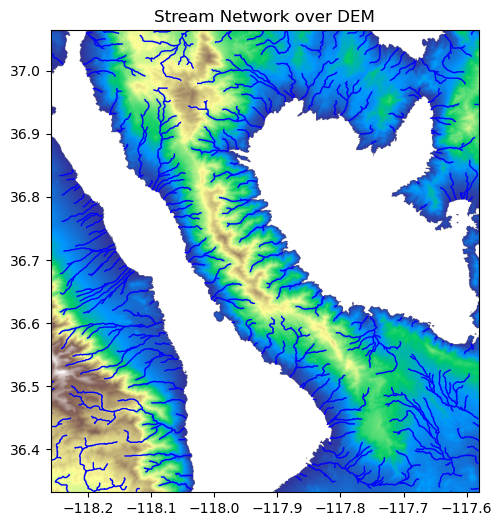

In [3]:
fd = tt3.FlowObject(dem)
s = tt3.StreamObject(fd, threshold=300)

fig, ax = plt.subplots(figsize=(8,6))
dem.plot(ax=ax, cmap='terrain')
s.plot(ax=ax, color='blue', linewidth=1)
ax.set_title("Stream Network over DEM")
plt.show()

In [4]:
outlet_mask = s.streampoi('outlets')
conf_mask   = s.streampoi('confluences')
heads_mask  = s.streampoi('channelheads')

outlet_ids = np.flatnonzero(outlet_mask)

print("POIs:")
print("  outlets:", int(outlet_mask.sum()))
print("  confluences:", int(conf_mask.sum()))
print("  channel heads:", int(heads_mask.sum()))
print("First 10 outlet node-ids:", outlet_ids[:10])

POIs:
  outlets: 189
  confluences: 238
  channel heads: 429
First 10 outlet node-ids: [  0   1  23  25  26 235 446 568 635 762]


In [5]:
by_outlet = {}

for o in outlet_ids:
    single_outlet_mask = np.zeros_like(outlet_mask, dtype=bool)
    single_outlet_mask[o] = True

    s_up_o = s.upstreamto(single_outlet_mask)
    conf_o = s_up_o.streampoi('confluences')
    conf_ids_o = np.flatnonzero(conf_o)

    heads_by_conf = {}
    for c_local in conf_ids_o:
        c_mask_local = np.zeros_like(conf_o, dtype=bool)
        c_mask_local[c_local] = True
        s_up_c = s_up_o.upstreamto(c_mask_local)
        head_ids_c = np.flatnonzero(s_up_c.streampoi('channelheads'))
        heads_by_conf[c_local] = head_ids_c

    by_outlet[o] = {
        "s_up": s_up_o,
        "confluences_local": conf_ids_o,
        "heads_by_confluence_local": heads_by_conf,
    }

# Compact print (optional)
for o, data in list(by_outlet.items())[:-1]:
    print(f"\nOutlet {o}:")
    print(f"  - Number of confluences: {len(data['confluences_local'])}")
    for c_local in data["confluences_local"]:
        heads_local = data["heads_by_confluence_local"].get(c_local, [])
        print(f"    Confluence {c_local}: {len(heads_local)} heads -> {heads_local}")


Outlet 0:
  - Number of confluences: 0

Outlet 1:
  - Number of confluences: 0

Outlet 23:
  - Number of confluences: 0

Outlet 25:
  - Number of confluences: 1
    Confluence 20: 2 heads -> [20 37]

Outlet 26:
  - Number of confluences: 1
    Confluence 16: 2 heads -> [48 61]

Outlet 235:
  - Number of confluences: 0

Outlet 446:
  - Number of confluences: 0

Outlet 568:
  - Number of confluences: 0

Outlet 635:
  - Number of confluences: 0

Outlet 762:
  - Number of confluences: 0

Outlet 821:
  - Number of confluences: 0

Outlet 961:
  - Number of confluences: 3
    Confluence 64: 4 heads -> [44 47 80 99]
    Confluence 90: 3 heads -> [16 49 68]
    Confluence 121: 2 heads -> [23 42]

Outlet 1046:
  - Number of confluences: 0

Outlet 1110:
  - Number of confluences: 0

Outlet 1146:
  - Number of confluences: 3
    Confluence 3: 4 heads -> [ 20  94  97 131]
    Confluence 16: 3 heads -> [ 78  81 115]
    Confluence 33: 2 heads -> [45 80]

Outlet 1252:
  - Number of confluences: 1
  

### channel-head coupeling

In [6]:
from src.coupling_analysis import CouplingAnalyzer
an = CouplingAnalyzer(fd, s, dem, connectivity=8)

In [7]:
outs = outlet_node_ids_from_streampoi(s)
print("Found", len(outs), "outlets.")
print("Outlet node IDs:", outs[:-1])

Found 189 outlets.
Outlet node IDs: [    0     1    23    25    26   235   446   568   635   762   821   961
  1046  1110  1146  1252  1490  1598  1637  1675  1780  1886  2228  2262
  2270  2416  2491  2645  2883  2945  2999  3000  3166  3349  3467  3567
  3629  3785  3844  3991  4438  4463  4589  4684  4826  4952  5255  5388
  5496  5554  5729  5772  5817  5951  5985  6160  6161  6306  6368  6420
  6442  6463  6464  6488  6508  6589  6624  6669  6686  6688  6702  6917
  7090  7150  7593  7594  7649  7709  7728  7951  7974  8248  8321  8336
  8380  8495  8580  8644  8684  8689  8703  8772  8786  8832  8900  8978
  9131  9234  9282  9347  9387  9400  9408  9492  9580  9589  9603  9631
  9738  9749  9753  9768  9828  9933  9974 10026 10027 10077 10119 10270
 10304 10387 10398 10444 10507 10548 10590 10591 10642 10884 10903 10935
 10996 11078 11270 11644 11790 11911 12019 12142 12177 12188 12381 12476
 12781 12878 13001 13017 13037 13092 13216 13340 13357 13445 13464 13481
 13515 13601 13

In [8]:
# === choose outlet ===
o = 15889
print("Selected outlet node id:", o)

# === run the same downstream logic ===
pairs_at_confluence, basin_heads = first_meet_pairs_for_outlet(s, o)
an = CouplingAnalyzer(fd, s, dem)
df = an.evaluate_pairs_for_outlet(o, pairs_at_confluence)
df.head()

Selected outlet node id: 15889


,outlet,confluence,head_1,head_2,touching,overlap_px,contact_px,size1_px,size2_px
0,15889,12637,12566,12607,True,0,76,418,300
1,15889,12871,12529,12687,False,0,0,305,348
2,15889,12954,12744,12875,True,0,64,300,357
3,15889,13038,12529,13002,False,0,0,305,305
4,15889,13038,12687,13002,True,0,28,348,305


In [9]:
def compute_coupling_all_outlets(s, fd, dem, outlets=None, warmup=True, connectivity=8):
    """
    Build a single DataFrame of coupling results for all (or selected) outlets.

    Columns:
      outlet, confluence, head_1, head_2, touching, overlap_px, contact_px, size1_px, size2_px
    """
    # 0) pick outlets
    if outlets is None:
        outlets = outlet_node_ids_from_streampoi(s)
    outlets = [int(o) for o in outlets]

    # 1) analyzer (we’ll reuse it; clear its cache per outlet to bound memory)
    an = CouplingAnalyzer(fd, s, dem, connectivity=connectivity)

    dfs = []
    for idx, o in enumerate(outlets, 1):
        # print small progress breadcrumb
        print(f"[{idx}/{len(outlets)}] outlet={o}", flush=True)

        # 2) first-meet pairs for this outlet
        pairs_at_confluence, basin_heads = first_meet_pairs_for_outlet(s, o)

        # 3) optional warm-up: precompute masks for heads in this basin
        if warmup and basin_heads:
            an._mask_cache.clear()          # keep cache limited per outlet
            # touch each head once to populate cache
            for h in basin_heads:
                _ = an.influence_mask(int(h))

        # 4) evaluate pairs → per-outlet DataFrame
        df_o = an.evaluate_pairs_for_outlet(o, pairs_at_confluence)
        if not df_o.empty:
            dfs.append(df_o)

    # 5) concat
    if not dfs:
        cols = ["outlet","confluence","head_1","head_2","touching","overlap_px","contact_px","size1_px","size2_px"]
        return pd.DataFrame(columns=cols)

    df_all = pd.concat(dfs, ignore_index=True)
    # nice ordering
    df_all.sort_values(["outlet","confluence","head_1","head_2"], inplace=True, ignore_index=True)
    return df_all

In [10]:
# All outlets
outs = outlet_node_ids_from_streampoi(s)
print("Found", len(outs), "outlets.")

df_all = compute_coupling_all_outlets(s, fd, dem, outlets=outs, warmup=True, connectivity=8)

print("Total pairs evaluated:", len(df_all))
print("Overall touching rate:", df_all["touching"].mean() if not df_all.empty else 0.0)
df_all.head()

Found 189 outlets.
[1/189] outlet=0
[2/189] outlet=1
[3/189] outlet=23
[4/189] outlet=25
[5/189] outlet=26
[6/189] outlet=235
[7/189] outlet=446
[8/189] outlet=568
[9/189] outlet=635
[10/189] outlet=762
[11/189] outlet=821
[12/189] outlet=961
[13/189] outlet=1046
[14/189] outlet=1110
[15/189] outlet=1146
[16/189] outlet=1252
[17/189] outlet=1490
[18/189] outlet=1598
[19/189] outlet=1637
[20/189] outlet=1675
[21/189] outlet=1780
[22/189] outlet=1886
[23/189] outlet=2228
[24/189] outlet=2262
[25/189] outlet=2270
[26/189] outlet=2416
[27/189] outlet=2491
[28/189] outlet=2645
[29/189] outlet=2883
[30/189] outlet=2945
[31/189] outlet=2999
[32/189] outlet=3000
[33/189] outlet=3166
[34/189] outlet=3349
[35/189] outlet=3467
[36/189] outlet=3567
[37/189] outlet=3629
[38/189] outlet=3785
[39/189] outlet=3844
[40/189] outlet=3991
[41/189] outlet=4438
[42/189] outlet=4463
[43/189] outlet=4589
[44/189] outlet=4684
[45/189] outlet=4826
[46/189] outlet=4952
[47/189] outlet=5255
[48/189] outlet=5388
[

,outlet,confluence,head_1,head_2,touching,overlap_px,contact_px,size1_px,size2_px
0,25,134,229,535,True,0,42,307,302
1,26,86,199,384,False,0,0,344,456
2,961,2989,3462,3487,True,0,26,423,374
3,961,2989,3462,3814,False,0,0,423,329
4,961,2989,3462,4308,False,0,0,423,315


In [13]:
df_touching = df_all[df_all["touching"] == True].copy()
print("Touching pairs:", len(df_touching))

Touching pairs: 137


In [14]:
df_touching.sort_values(
    ["outlet", "confluence", "head_1", "head_2"],
    inplace=True,
    ignore_index=True
)
df_touching.head(20)

,outlet,confluence,head_1,head_2,touching,overlap_px,contact_px,size1_px,size2_px
0,25,134,229,535,True,0,42,307,302
1,961,2989,3462,3487,True,0,26,423,374
2,961,3683,3814,4308,True,0,1,329,315
3,1146,1248,1555,2412,True,0,3,317,302
4,1675,1244,1100,1627,True,0,31,366,303
5,1675,1591,1627,2375,True,0,31,303,396
6,1675,1708,1629,2110,True,0,41,301,397
7,1675,2076,2110,2536,True,0,47,397,301
8,1780,1948,2113,2665,True,0,21,456,341
9,1780,2910,2665,3368,True,0,63,341,378


In [15]:
summary_touch = (
    df_touching.groupby("outlet")
               .size()
               .reset_index(name="n_touching_pairs")
               .sort_values("n_touching_pairs", ascending=False)
)
summary_touch.head(10)

,outlet,n_touching_pairs
37,10027,12
51,15882,11
53,15889,10
13,4589,7
19,6420,6
44,12142,6
11,3785,5
20,6624,5
3,1675,4
40,10507,4


(<Figure size 1000x800 with 1 Axes>,
 <Axes: title={'center': 'Outlet 10027 — 12 coupled pairs (crop)'}>)

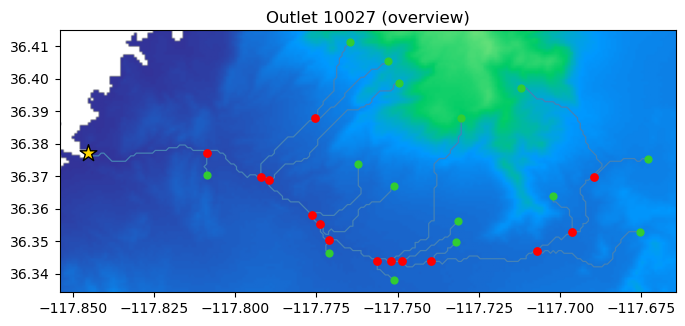

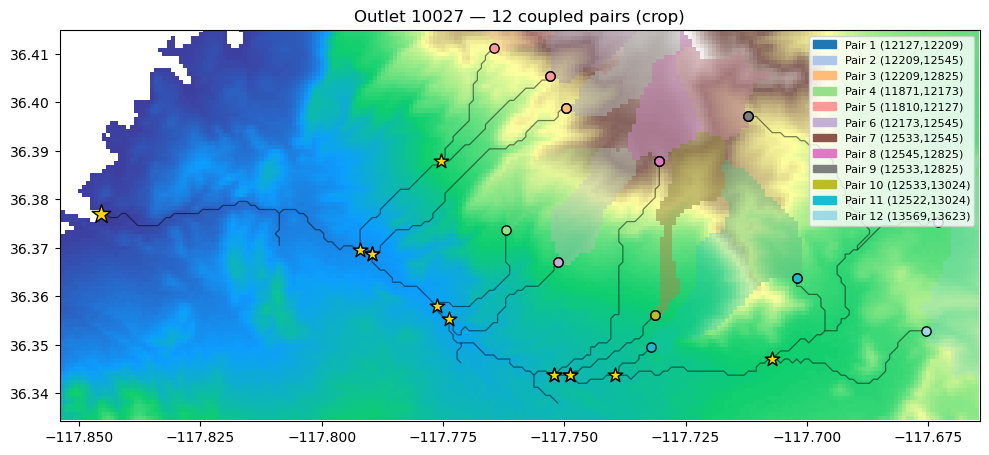

In [16]:
plot_outlet_view(s, 10027, dem, view_mode="overview")



# overview of all pairs still needs 'an'
plot_all_coupled_pairs_for_outlet(fd, s, dem, an, df_touching, 10027, view_mode="crop")

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (97, 228) and arg 2 with shape (878, 814).

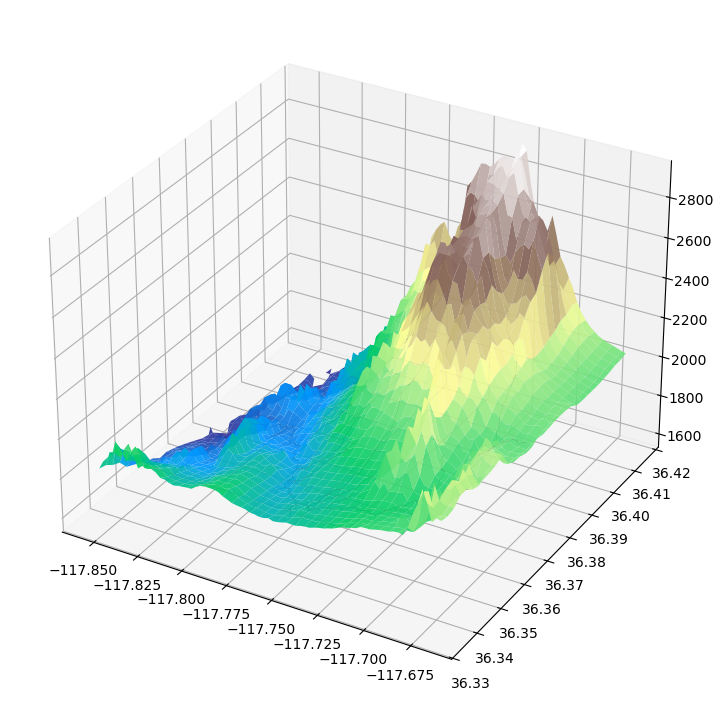

In [17]:
fig, ax = plot_all_coupled_pairs_for_outlet_3d(
    fd, s, dem, an, df_touching,
    outlet_id=10027,
    view_mode="crop",
    pad_frac=0.05,
    alpha=0.35,
    max_pairs=8,
    dem_stride=3,  # speed-up
    surface_kwargs=dict(cmap="terrain", alpha=0.92),
    stream_kwargs=dict(color="k", linewidth=0.5, alpha=0.55),
    z_exaggeration=1.3
)
plt.show()
